# MLOPs on GCP course - MLFlow introduction

<img src=https://www.headmind.com/wp-content/uploads/2024/01/logo_dark.png width="200">

<img src=https://www.isae-supaero.fr/local/cache-vignettes/L190xH102/siteon0-e5814.png width="200">

*Context*

Credit risk is the risk that a customer doesn't pay back the money they borrowed from a bank. Banks do credit risk modelling to minimize their expected credit loss. ML models can be trained to classify whether a customer is at risk or not.

*Dataset*

The German Credit Risk dataset is used.

The dataset is anonymized because it contains personal identifiable information (PII) on the bank customers. The features are described in the data/features.txt file.

*Objectives*

- Dataset exploration : Using EDA, explore the relevant data 
- ML implementation : train a Random Forest Classifier with Optuna 

*Notebook made by Headmind Partners AI & Blockchain*

## Libraries

In [ ]:
%pip install -r requirements.txt

In [3]:
import pickle
import numpy as np
import mlflow
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
import optuna
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, f1_score

from IPython.display import Image
pd.set_option("display.max_columns", 500)

## Data Exploration

In [13]:
filename = "data/dataset.parquet"

df = pd.read_parquet(filename)
df.head()
### REMPLACER IMPORT DES DONN2ES

,checking_account_status,duration_month,credit_history,purpose,credit_amount,savings_account,employment_duration,installment_rate,personal_status_sex,other_debtors,present_residence_since,property,age,other_installment_plans,housing,existing_credits_count,job,dependents_count,telephone,foreign_worker,class
0,< 0 DM,6,critical account/ other credits existing (not ...,radio/television,1169,A65,.. >= 7 years,4,male : single,none,4,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes,1
1,0 <= ... < 200 DM,48,existing credits paid back duly till now,radio/television,5951,A61,1 <= ... < 4 years,2,female : divorced/separated/married,none,2,real estate,22,none,own,1,skilled employee / official,1,none,yes,2
2,no checking account,12,critical account/ other credits existing (not ...,education,2096,A61,4 <= ... < 7 years,2,male : single,none,3,real estate,49,none,own,1,unskilled - resident,2,none,yes,1
3,< 0 DM,42,existing credits paid back duly till now,furniture/equipment,7882,A61,4 <= ... < 7 years,2,male : single,guarantor,4,building society savings agreement/life insurance,45,none,for free,1,skilled employee / official,2,none,yes,1
4,< 0 DM,24,delay in paying off in the past,car (new),4870,A61,1 <= ... < 4 years,3,male : single,none,4,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes,2


The goal is to predict if a bank can give a credit to a customer according to its profile

Question: Identify the target field

In [15]:
# Identify target field
#########################
# target_field = "..."
target_field = "class" # TODO
#########################

In [ ]:
# Let's rename the target field
df = df.rename(columns={target_field:'risk'})
# And change the label values 
df['risk'] = df['risk'].map({1:0,2:1})

y = df['risk']
X = df.drop(columns=['risk'])

This is a binary classification problem where
-  y = 1 if the customer is at risk
-  y = 0 if the customer is "bankable"

In real life banks assess customer risk with more than two values (risky or not risky).

In our case, what trick would you suggest to get n risk values (with n>2) ? (with probabilities for instance)

--------------------------
ANSWER HERE

--------------------------

### Using seaborn to explore data 

Correlation matrixes and features distributions according to the credit risk are displayed using the *seaborn* library.

<Axes: >

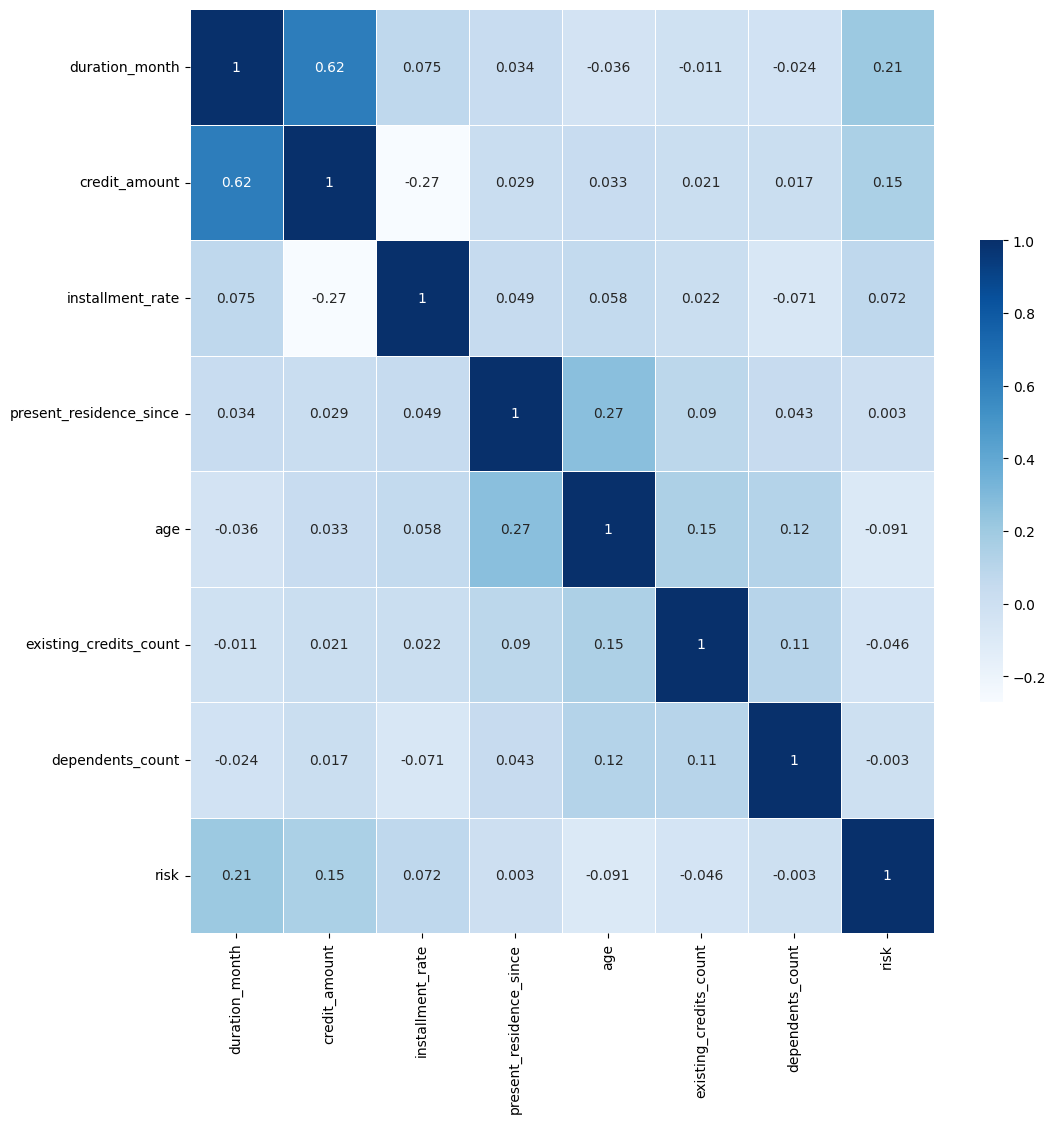

In [19]:
# Correlation matrix
corr = df.corr(numeric_only = True)
plt.figure(figsize=(12,12))
sns.heatmap(corr, cmap="Blues", annot=True, linewidths=.5, cbar_kws={"shrink": .5})


Question : Do you consider the dataset unbalanced ? Compute the label proportion. If a dataset is unbalanced what are the risks on the model? Which method would you use to manage an unbalanced dataset?

--------------------------
ANSWER HERE

--------------------------

## Encoding

Preliminary data exploration helped us discover all the features in the dataset, their distributions and correlations.

The categorical features now have to be encoded

In [22]:
df

,checking_account_status,duration_month,credit_history,purpose,credit_amount,savings_account,employment_duration,installment_rate,personal_status_sex,other_debtors,present_residence_since,property,age,other_installment_plans,housing,existing_credits_count,job,dependents_count,telephone,foreign_worker,risk
0,< 0 DM,6,critical account/ other credits existing (not ...,radio/television,1169,A65,.. >= 7 years,4,male : single,none,4,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes,0
1,0 <= ... < 200 DM,48,existing credits paid back duly till now,radio/television,5951,A61,1 <= ... < 4 years,2,female : divorced/separated/married,none,2,real estate,22,none,own,1,skilled employee / official,1,none,yes,1
2,no checking account,12,critical account/ other credits existing (not ...,education,2096,A61,4 <= ... < 7 years,2,male : single,none,3,real estate,49,none,own,1,unskilled - resident,2,none,yes,0
3,< 0 DM,42,existing credits paid back duly till now,furniture/equipment,7882,A61,4 <= ... < 7 years,2,male : single,guarantor,4,building society savings agreement/life insurance,45,none,for free,1,skilled employee / official,2,none,yes,0
4,< 0 DM,24,delay in paying off in the past,car (new),4870,A61,1 <= ... < 4 years,3,male : single,none,4,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,no checking account,12,existing credits paid back duly till now,furniture/equipment,1736,A61,4 <= ... < 7 years,3,female : divorced/separated/married,none,4,real estate,31,none,own,1,unskilled - resident,1,none,yes,0
996,< 0 DM,30,existing credits paid back duly till now,car (used),3857,A61,1 <= ... < 4 years,4,male : divorced/separated,none,4,building society savings agreement/life insurance,40,none,own,1,management/ self-employed/highly qualified emp...,1,"yes, registered under the customers name",yes,0
997,no checking account,12,existing credits paid back duly till now,radio/television,804,A61,.. >= 7 years,4,male : single,none,4,"car or other, not in attribute 6",38,none,own,1,skilled employee / official,1,none,yes,0
998,< 0 DM,45,existing credits paid back duly till now,radio/television,1845,A61,1 <= ... < 4 years,4,male : single,none,4,unknown / no property,23,none,for free,1,skilled employee / official,1,"yes, registered under the customers name",yes,1


In [26]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_feat = X.select_dtypes(include=numerics).columns.tolist()

##############################################
# Pick the right categorical features to encode
categorical_feat = ["checking_account_status","credit_history","purpose",'savings_account',"employment_duration","personal_status_sex","other_debtors","property","other_installment_plans","housing","job","telephone","foreign_worker"] # TODO
##############################################

onehot_encoder = OneHotEncoder()

# Fit_transform - create a X_enc dataframe from the X dataframe
X_enc_array = onehot_encoder.fit_transform(X[categorical_feat])
X_enc = pd.DataFrame(X_enc_array.toarray(), columns=onehot_encoder.get_feature_names_out(input_features=categorical_feat))
X_enc[numeric_feat] = X[numeric_feat]

display(X_enc.head())


,checking_account_status_0 <= ... < 200 DM,checking_account_status_< 0 DM,checking_account_status_>= 200 DM / salary assignments for at least 1 year,checking_account_status_no checking account,credit_history_all credits at this bank paid back duly,credit_history_critical account/ other credits existing (not at this bank),credit_history_delay in paying off in the past,credit_history_existing credits paid back duly till now,credit_history_no credits taken/ all credits paid back duly,purpose_business,purpose_car (new),purpose_car (used),purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_others,purpose_radio/television,purpose_repairs,purpose_retraining,savings_account_A61,savings_account_A62,savings_account_A63,savings_account_A64,savings_account_A65,employment_duration_.. >= 7 years,employment_duration_... < 1 year,employment_duration_1 <= ... < 4 years,employment_duration_4 <= ... < 7 years,employment_duration_unemployed,personal_status_sex_female : divorced/separated/married,personal_status_sex_male : divorced/separated,personal_status_sex_male : married/widowed,personal_status_sex_male : single,other_debtors_co-applicant,other_debtors_guarantor,other_debtors_none,property_building society savings agreement/life insurance,"property_car or other, not in attribute 6",property_real estate,property_unknown / no property,other_installment_plans_bank,other_installment_plans_none,other_installment_plans_stores,housing_for free,housing_own,housing_rent,job_management/ self-employed/highly qualified employee/ officer,job_skilled employee / official,job_unemployed/ unskilled - non-resident,job_unskilled - resident,telephone_none,"telephone_yes, registered under the customers name",foreign_worker_no,foreign_worker_yes,duration_month,credit_amount,installment_rate,present_residence_since,age,existing_credits_count,dependents_count
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,6,1169,4,4,67,2,1
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,48,5951,2,2,22,1,1
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,12,2096,2,3,49,1,2
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,42,7882,2,4,45,1,2
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,24,4870,3,4,53,2,2


What is a one-hot encoder? How would it transform the following pandas Series: ['Cat','Cat','Dog','Cat','Bird','Dog']?

--------------------------
ANSWER HERE

--------------------------

In [28]:
with open("data/one_hot_encoder.pkl", 'wb') as file:
    pickle.dump(onehot_encoder, file)

## ML Modeling

### Train/test split

Question : Split X and y to fit the model. Make sure the risk proportion in the train set are the same as in the test set using the argument *stratify*. Use random_state = 16

In [29]:
X_train,X_test,y_train,y_test = train_test_split(X_enc,y,test_size=0.2, stratify=y, random_state=16) # TODO

### Training an ML model
During the rest of this workshop, we'll train a random forest classifier. What other models would be appropriate for the current problem? Justify your answer.

--------------------------
ANSWER HERE

--------------------------

#### Training with default hyperparameters


In [30]:
# Basic configuration

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

To run the MLFlow server, use the following command in your terminal (make sure you're in the right folder)


```mlflow server```

In [36]:

mlflow.set_experiment(experiment_name="finetune-creditrisk")
with mlflow.start_run(run_name="RandomForest_NoOptimization"):
    # log params
    params = rf_clf.get_params()
    mlflow.log_param("n_estimators", params["n_estimators"])
    mlflow.log_param("bootstrap", params["bootstrap"])
    mlflow.log_param("min_samples_leaf", params["min_samples_leaf"])
    mlflow.log_param("max_depth", params["max_depth"])

    # log metrics
    y_pred = rf_clf.predict_proba(X_test)[:,1]
    mlflow.log_metric("auc", roc_auc_score(y_test,y_pred))
    mlflow.log_metric("f1-score", f1_score(y_test, rf_clf.predict(X_test)))
    
    mlflow.sklearn.log_model(rf_clf, artifact_path="sklearn-model",
        registered_model_name="sk-learn-random-forest")
    
    mlflow.log_artifact(local_path='data/one_hot_encoder.pkl', artifact_path="")

2025/02/28 17:37:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'sk-learn-random-forest' already exists. Creating a new version of this model...
Created version '3' of model 'sk-learn-random-forest'.


#### Optimizing hyperparameters with Optuna

<a href=https://optuna.readthedocs.io/en/stable/index.html> Optuna </a> is a hyperparameter fine-tuning framework.

To use it, you first define a trial, a scoring function, and a set of hyperparameters to fine-tune, using 'suggest' methods.

Then, you choose an heuristic and optuna will try different sets of hyperparameters and log the KPIs.

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify = y_train, random_state=16)

def objective_rf(trial):
    rf_params = {
            # Parameter space definition
            #################################################################
            'n_estimators' : trial.suggest_int('n_estimators',low=50,high=250),
            'max_depth' : trial.suggest_int('max_depth',low=2,high=10),
            'max_features' : trial.suggest_categorical('max_features', ["sqrt", None]),
            'min_samples_leaf' : trial.suggest_float("min_samples_leaf", low = 0.001, high = 0.1)
            #################################################################
            }

    rf_classifier = RandomForestClassifier(random_state=42)
    rf_classifier.set_params(**rf_params)

    rf_classifier.fit(X_train, y_train)

    # Log metrics
    y_pred = rf_classifier.predict(X_val)
    score=f1_score(y_val, y_pred)
    mlflow.log_metric("auc", roc_auc_score(y_val,y_pred))
    mlflow.log_metric("f1-score", score)
    return score

In [41]:
study = optuna.create_study(direction="maximize")
full_objective = lambda trial: objective_rf(trial)
mlflow.set_experiment(experiment_name="finetune-creditrisk")
with mlflow.start_run(run_name="RandomForest_Finetuning_exp"):
    study.optimize(full_objective, n_trials=30, timeout=600)
rf_params = study.best_trial.params

[I 2025-02-28 17:43:31,794] A new study created in memory with name: no-name-0a7b01d6-f685-4705-9c1b-2c0a826a5e18
[I 2025-02-28 17:43:34,084] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 201, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 0.04357523998123628}. Best is trial 0 with value: 0.0.
[I 2025-02-28 17:43:35,880] Trial 1 finished with value: 0.3142857142857143 and parameters: {'n_estimators': 135, 'max_depth': 9, 'max_features': None, 'min_samples_leaf': 0.07483874808376137}. Best is trial 1 with value: 0.3142857142857143.
[I 2025-02-28 17:43:38,220] Trial 2 finished with value: 0.3783783783783784 and parameters: {'n_estimators': 166, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 0.04973281028723172}. Best is trial 2 with value: 0.3783783783783784.
[I 2025-02-28 17:43:39,049] Trial 3 finished with value: 0.2608695652173913 and parameters: {'n_estimators': 172, 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 0.09900284647373

What is the difference between a train, validation, and test set. What are the risks if there is overlapping between the validation and test set?

--------------------------
ANSWER HERE

--------------------------

In [42]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.set_params(**rf_params)

X_train_val, y_train_val = pd.concat((X_train, X_val)), pd.concat((y_train, y_val))

rf_classifier.fit(X_train_val, y_train_val)
with mlflow.start_run(run_name="RandomForest_Optimization"):
    # log params
    mlflow.log_param("n_estimators", rf_params["n_estimators"])
    mlflow.log_param("min_samples_leaf", rf_params["min_samples_leaf"])
    mlflow.log_param("max_depth", rf_params["max_depth"])
    mlflow.log_param('max_features', rf_params['max_features'])

    # log metrics
    y_pred = rf_classifier.predict_proba(X_test)[:,1]
    mlflow.log_metric("auc", roc_auc_score(y_test,y_pred))
    mlflow.log_metric("f1-score", f1_score(y_test, rf_classifier.predict(X_test)))
    
    mlflow.sklearn.log_model(rf_clf, artifact_path="sklearn-model",
        registered_model_name="sk-learn-random-forest-finetuned")
    mlflow.log_artifact(local_path='data/one_hot_encoder.pkl', artifact_path="")

2025/02/28 17:45:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'sk-learn-random-forest-finetuned'.
Created version '1' of model 'sk-learn-random-forest-finetuned'.


# Retrieves a model logged on MLFlow - on run_id

In [43]:
import mlflow
from IPython.display import display

experiment_name = ["finetune-creditrisk"]
run_name = "RandomForest_Optimization"

# Search for the run using the experiment name and run name
runs = mlflow.search_runs(experiment_names=experiment_name)

display(runs)

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.f1-score,metrics.auc,params.n_estimators,params.max_depth,params.max_features,params.min_samples_leaf,params.bootstrap,tags.mlflow.log-model.history,tags.mlflow.source.type,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.runName
0,272321366c024689a3a3f64c718ea706,281785168593599018,FINISHED,file:///c:/vyiu/mlops/mlops-on-gcp/labs/1_mlfl...,2025-02-28 16:45:02.291000+00:00,2025-02-28 16:45:21.733000+00:00,0.563107,0.805833,150,9,None,0.0013033790363843577,None,"[{""run_id"": ""272321366c024689a3a3f64c718ea706""...",LOCAL,c:\Users\vyiu\AppData\Local\miniforge3\envs\ml...,vyiu,RandomForest_Optimization
1,32e8a3b99cae41ab9f9a2d89904d3057,281785168593599018,FINISHED,file:///c:/vyiu/mlops/mlops-on-gcp/labs/1_mlfl...,2025-02-28 16:43:31.928000+00:00,2025-02-28 16:44:06.701000+00:00,0.040816,0.510417,None,None,None,None,None,None,LOCAL,c:\Users\vyiu\AppData\Local\miniforge3\envs\ml...,vyiu,RandomForest_Finetuning_exp
2,ae005aeeadc349eca81250cd36a4e65f,281785168593599018,FINISHED,file:///c:/vyiu/mlops/mlops-on-gcp/labs/1_mlfl...,2025-02-28 16:37:16.384000+00:00,2025-02-28 16:37:30.770000+00:00,0.494624,0.795000,100,None,None,1,True,"[{""run_id"": ""ae005aeeadc349eca81250cd36a4e65f""...",LOCAL,c:\Users\vyiu\AppData\Local\miniforge3\envs\ml...,vyiu,RandomForest_NoOptimization
3,e2492247dc324ac198245ba983fe17fb,281785168593599018,FINISHED,file:///c:/vyiu/mlops/mlops-on-gcp/labs/1_mlfl...,2025-02-28 16:34:46.038000+00:00,2025-02-28 16:34:58.244000+00:00,0.494624,0.795000,100,None,None,1,True,"[{""run_id"": ""e2492247dc324ac198245ba983fe17fb""...",LOCAL,c:\Users\vyiu\AppData\Local\miniforge3\envs\ml...,vyiu,RandomForest_NoOptimization
4,20cc0b53c64f4d849d666e5a0cd32f61,281785168593599018,FAILED,file:///c:/vyiu/mlops/mlops-on-gcp/labs/1_mlfl...,2025-02-28 16:34:02.999000+00:00,2025-02-28 16:34:34.226000+00:00,0.494624,0.795000,100,None,None,1,True,"[{""run_id"": ""20cc0b53c64f4d849d666e5a0cd32f61""...",LOCAL,c:\Users\vyiu\AppData\Local\miniforge3\envs\ml...,vyiu,RandomForest_NoOptimization


In [44]:
last_run_id = runs.loc[runs["tags.mlflow.runName"] == run_name]
last_run_id.sort_values(by = ["end_time"], ascending=False, inplace=True)
run_id = last_run_id.iloc[0]["run_id"]

C:\Users\vyiu\AppData\Local\Temp\ipykernel_20080\1308768644.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_run_id.sort_values(by = ["end_time"], ascending=False, inplace=True)


In [45]:
# Retrieves a model from MLFlow
model = mlflow.sklearn.load_model(f"runs:/{run_id}/sklearn-model")
model.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0])

# Upgrades the model status

In [47]:
from mlflow import MlflowClient

client = MlflowClient()
client.transition_model_version_stage(
    name="sk-learn-random-forest-finetuned", version=1, stage="Production"
)

C:\Users\vyiu\AppData\Local\Temp\ipykernel_20080\799320548.py:4: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1740761121584, current_stage='Production', description=None, last_updated_timestamp=1740761182929, name='sk-learn-random-forest-finetuned', run_id='272321366c024689a3a3f64c718ea706', run_link=None, source='file:///c:/vyiu/mlops/mlops-on-gcp/labs/1_mlflow/mlruns/281785168593599018/272321366c024689a3a3f64c718ea706/artifacts/sklearn-model', status='READY', status_message=None, tags={}, user_id=None, version=1>

# Retrieves the model from the status

In [49]:
import mlflow

model_name = "sk-learn-random-forest-finetuned"
model_version = 1

model = mlflow.sklearn.load_model(model_uri=f"models:/{model_name}/{model_version}")